In [243]:
import re
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go

In [244]:
data = pd.read_csv("Raw_Dataset.csv")

## Introdução
Durante minha migração de carreira por muitas vezes acabei me vendo um pouco desorientado sobre quais habilidades são mais buscadas dentro do mercado de Ciência e Análise de Dados. Buscando solucionar essa dúvida, que acredito que seja também de muitas outras pessoas, encontrei uma base de dados no Kaggle que poderia me ajudar a entender melhor este mercado. A base de dados se refere a vagas para Cientistas de Dados no Reino Unido e traz informações valiosas sobre este campo do conhecimento, como quais são as empresas com vagas em aberto, suas avaliações, o cargo, localização, quantidade de dias que a vaga está disponível, salário e habilidades. De posse destes dados busquei realizar uma análise para entender melhor o mercado para guiar minhas escolhas e auxiliar outras pessoas com base nas informações por mim encontradas.

## Objetivos
**1. Análise das Vagas de Cientista de Dados no Reino Unido:**

    O objetivo principal foi analisar as habilidades técnicas mais demandadas e os salários oferecidos para vagas de cientistas de dados no Reino Unido. Fizemos isso dividindo as vagas por níveis profissionais (júnior, pleno, e sênior) e estudando suas particularidades.

**2. Exploração das Habilidades:**

    Identifiquei as habilidades mais comuns exigidas por nível de profissional (júnior, pleno, sênior), ajudando a entender quais tecnologias e competências são prioritárias em cada etapa da carreira.

**3. Análise Salarial por Nível Profissional:**

    Estudei a média e mediana salarial para cada nível de profissional, comparando as diferenças salariais entre vagas de júnior, pleno e sênior, e identificando outliers que poderiam influenciar essas métricas.

**4. Identificação de Vagas Não Classificadas:**

    Criei uma categoria de “outros” para vagas que não se encaixaram claramente nas classificações de júnior, pleno ou sênior analisando suas particularidades separadamente.

### Verificando informações gerais sobre a base de dados

In [245]:
data.head()

,Company,Company Score,Job Title,Location,Date,Salary,Skills
0,Razorpoint,3.4,Junior Data Scientist,"Manchester, England",3d,£35K (Employer est.),"Data mining, Big data, R, Data analysis skills..."
1,tower Hamlets,3.7,Assistant Data Scientist (Graduate) | R-2375,"London, England",5d,£31.00 Per Hour (Employer est.),"R, SQL, JavaScript, Python"
2,TW,4.0,Data Scientist,"Nottingham, England",30d+,£50K - £65K (Employer est.),"SQL, Maths, Data science, Python"
3,NatWest Group,4.6,Data Scientist,"Edinburgh, Scotland",2d,£41K - £54K (Glassdoor est.),"Software deployment, Data analysis skills, Sta..."
4,iwoca,3.9,Data Scientist - Ops,"London, England",7d,£60K - £90K (Employer est.),"MATLAB, R, Maths, C, Machine learning"


In [246]:
data.shape

(750, 7)

In [247]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Company        750 non-null    object 
 1   Company Score  697 non-null    float64
 2   Job Title      750 non-null    object 
 3   Location       750 non-null    object 
 4   Date           750 non-null    object 
 5   Salary         635 non-null    object 
 6   Skills         742 non-null    object 
dtypes: float64(1), object(6)
memory usage: 41.1+ KB


In [248]:
data.isnull().sum()

Company            0
Company Score     53
Job Title          0
Location           0
Date               0
Salary           115
Skills             8
dtype: int64

In [249]:
data["Job Title"].value_counts()

Data Scientist                                                                       67
Senior Data Scientist                                                                36
Machine Learning Engineer                                                            23
Senior Machine Learning Engineer                                                     11
Lead Data Scientist                                                                  10
                                                                                     ..
Consultant - Analytics & Artificial Intelligence - Data & AI Architect                1
Digital Audit Manager - Data Analytics                                                1
Senior Consultant - Data & AI Strategy - Data Management                              1
Associate, Data Science Analyst – Global Oil Markets (Hybrid - 3/2 Work Schedule)     1
Senior Deep Learning / AI Engineer                                                    1
Name: Job Title, Length: 563, dt

### Preenchendo valores nulos de cada coluna

In [250]:
data.Skills.fillna("Not Informed", inplace = True)

In [251]:
data.Salary.fillna("0.0", inplace = True)

In [252]:
data["Company Score"].fillna(0.0, inplace = True)

### Calculando média de salário anual por vaga

In [253]:
def process_salary(salary):
    # Remover o texto adicional após o salário
    salary = salary.split('(')[0].strip()
    
    # Verificar se o salário está em faixa (£XK - £YK)
    if '-' in salary:
        # Extrair os valores numéricos
        numbers = re.findall(r'\d+', salary)
        if len(numbers) == 2:
            min_salary = int(numbers[0]) * 1000
            max_salary = int(numbers[1]) * 1000
            return (min_salary + max_salary) / 2
    
    # Verificar se é um valor fixo (£XK)
    elif 'K' in salary:
        # Extrair o valor fixo
        fixed_salary = int(re.findall(r'\d+', salary)[0]) * 1000
        return fixed_salary
    
    # Verificar se o salário está em valores por hora (Per Hour)
    elif 'Per Hour' in salary:
        hourly_rate = float(re.findall(r'\d+\.\d+', salary)[0])
        monthly_salary = hourly_rate * 44 * 4  # Salário mensal estimado
        annual_salary = monthly_salary * 12    # Convertendo para anual
        return annual_salary
    
    # Retornar NaN se não houver um padrão correspondente
    return None

# Aplicar a função para processar a coluna de salários
data['Average Salary'] = data['Salary'].apply(process_salary)

In [254]:
data.head()

,Company,Company Score,Job Title,Location,Date,Salary,Skills,Average Salary
0,Razorpoint,3.4,Junior Data Scientist,"Manchester, England",3d,£35K (Employer est.),"Data mining, Big data, R, Data analysis skills...",35000.0
1,tower Hamlets,3.7,Assistant Data Scientist (Graduate) | R-2375,"London, England",5d,£31.00 Per Hour (Employer est.),"R, SQL, JavaScript, Python",65472.0
2,TW,4.0,Data Scientist,"Nottingham, England",30d+,£50K - £65K (Employer est.),"SQL, Maths, Data science, Python",57500.0
3,NatWest Group,4.6,Data Scientist,"Edinburgh, Scotland",2d,£41K - £54K (Glassdoor est.),"Software deployment, Data analysis skills, Sta...",47500.0
4,iwoca,3.9,Data Scientist - Ops,"London, England",7d,£60K - £90K (Employer est.),"MATLAB, R, Maths, C, Machine learning",75000.0


### Identificando habilidades técnicas com maior demanda

In [255]:
def clean_and_split_skills(skills):
    if pd.isnull(skills):
        return []  # Retornar lista vazia para valores nulos
    return [skill.strip().lower() for skill in skills.split(',')]

In [256]:
data['Skills List'] = data['Skills'].apply(clean_and_split_skills)

In [257]:
all_skills = [skill for sublist in data['Skills List'] for skill in sublist]

In [258]:
skill_counts = Counter(all_skills)
skill_df = pd.DataFrame(skill_counts.items(), columns=['Skill', 'Count']).sort_values(by='Count', ascending=False)

In [259]:
skill_df

,Skill,Count
12,machine learning,306
5,sql,180
19,tensorflow,167
2,r,147
59,azure,128
...,...,...
182,financial report writing,1
181,raspberry pi,1
180,arduino,1
179,php,1


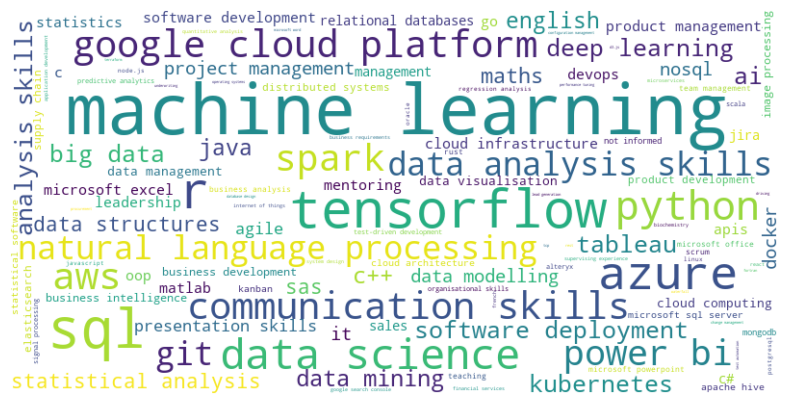

In [260]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(skill_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Por serem muitas habilidades em demanda, optei por criar um gráfico de barras com as 15 principais habilidades requeridas

In [261]:
top_15_skills = skill_df.head(15)

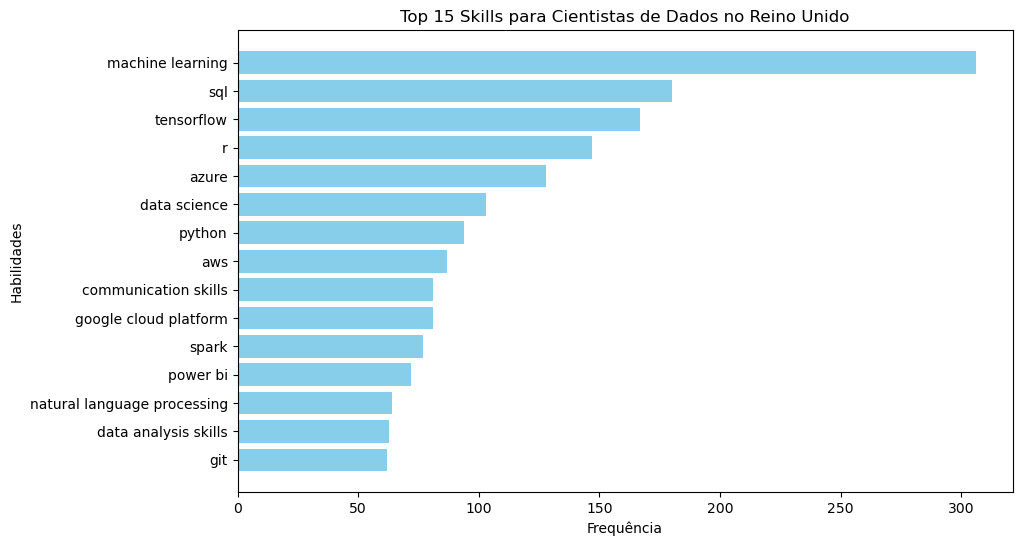

In [262]:
plt.figure(figsize=(10, 6))
plt.barh(top_15_skills['Skill'], top_15_skills['Count'], color='skyblue')
plt.xlabel('Frequência')
plt.ylabel('Habilidades')
plt.title('Top 15 Skills para Cientistas de Dados no Reino Unido')
plt.gca().invert_yaxis()  # Inverter a ordem para que a mais frequente fique no topo
plt.show()

In [263]:
# Filtrar as colunas de salário nas vagas de Cientista de Dados
data_jobs_with_salary = data.dropna(subset=['Average Salary'])

# Calcular o salário médio entre as vagas de Cientista de Dados
average_data_scientist_salary = data_jobs_with_salary['Average Salary'].mean()

print(f"Salário médio para Cientistas de Dados: £{average_data_scientist_salary:.2f}")

Salário médio para Cientistas de Dados: £65490.56


In [264]:
median_data_scientist_salary = data_jobs_with_salary["Average Salary"].median()
print(f"Mediana dos salários para Cientistas de Dados é: £{median_data_scientist_salary:.2f}")

Mediana dos salários para Cientistas de Dados é: £63000.00


### Identificando as habilidades mais requisitadas para profissionais Junior

In [265]:
junior_jobs = data[data['Job Title'].str.contains('Junior|Entry Level|Trainee|Graduate', case=False, na=False)]

In [266]:
junior_jobs

,Company,Company Score,Job Title,Location,Date,Salary,Skills,Average Salary,Skills List
0,Razorpoint,3.4,Junior Data Scientist,"Manchester, England",3d,£35K (Employer est.),"Data mining, Big data, R, Data analysis skills...",35000.0,"[data mining, big data, r, data analysis skill..."
1,tower Hamlets,3.7,Assistant Data Scientist (Graduate) | R-2375,"London, England",5d,£31.00 Per Hour (Employer est.),"R, SQL, JavaScript, Python",65472.0,"[r, sql, javascript, python]"
8,MLN Security,3.2,Junior Data Scientist,"Barking, East of England, England",30d+,£49K - £70K (Glassdoor est.),"TensorFlow, SAS, Big data, Java, AWS",59500.0,"[tensorflow, sas, big data, java, aws]"
11,Volcore,3.9,Graduate Software Engineer / Data Scientist: F...,"Manchester, England",3d,£48K (Employer est.),"Cloud infrastructure, Rust, Go, SQL, C++",48000.0,"[cloud infrastructure, rust, go, sql, c++]"
53,Razorpoint,4.4,Junior Data Analyst,"London, England",20d,FCFA 102K (Employer est.),"TensorFlow, Azure, R, Google Cloud Platform, T...",102000.0,"[tensorflow, azure, r, google cloud platform, ..."
62,Robin AI,4.3,Junior Applied Scientist,"London, England",18d,£34K - £65K (Glassdoor est.),"TensorFlow, Application development, Machine l...",49500.0,"[tensorflow, application development, machine ..."
74,Information Tech Consultants,3.4,Junior Big Data Engineer,"London, England",5d,£39K - £42K (Employer est.),"Power BI, R, SQL, Agile, IT",40500.0,"[power bi, r, sql, agile, it]"


C:\Users\luizs\AppData\Local\Temp\ipykernel_1700\302166865.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



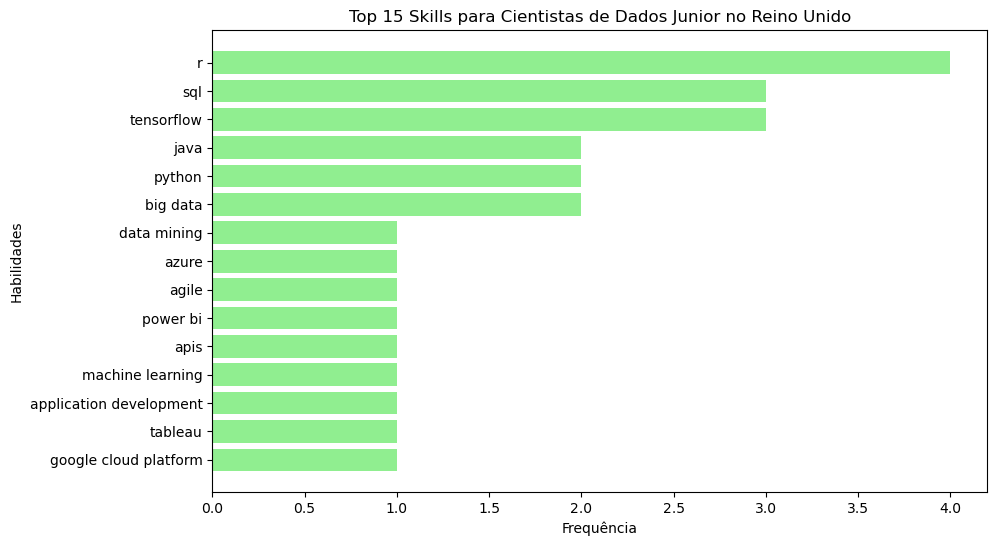

In [267]:
# Limpar e separar as habilidades nas vagas de nível Júnior
junior_jobs['Skills List'] = junior_jobs['Skills'].apply(clean_and_split_skills)

# Unir todas as listas de habilidades em uma única lista
junior_skills = [skill for sublist in junior_jobs['Skills List'] for skill in sublist]

# Contar a frequência de cada habilidade
junior_skill_counts = Counter(junior_skills)

# Converter a contagem de habilidades em um DataFrame
junior_skill_df = pd.DataFrame(junior_skill_counts.items(), columns=['Skill', 'Count']).sort_values(by='Count', ascending=False)

# Visualizar as 10 principais habilidades em vagas de nível júnior
top_10_junior_skills = junior_skill_df.head(15)

# Gráfico de barras das 10 principais habilidades
plt.figure(figsize=(10, 6))
plt.barh(top_10_junior_skills['Skill'], top_10_junior_skills['Count'], color='lightgreen')
plt.xlabel('Frequência')
plt.ylabel('Habilidades')
plt.title('Top 15 Skills para Cientistas de Dados Junior no Reino Unido')
plt.gca().invert_yaxis()
plt.show()

In [268]:
# Filtrar as colunas de salário nas vagas Júnior
junior_jobs_with_salary = junior_jobs.dropna(subset=['Average Salary'])

# Calcular o salário médio entre as vagas de nível Júnior
average_junior_salary = junior_jobs_with_salary['Average Salary'].mean()

print(f"Salário médio para vagas de nível Júnior: £{average_junior_salary:.2f}")

Salário médio para vagas de nível Júnior: £57138.86


In [269]:
median_junior_salary = junior_jobs_with_salary["Average Salary"].median()
print(f"Mediana dos salários para vagas de nível Júnior: £{median_junior_salary:.2f}")

Mediana dos salários para vagas de nível Júnior: £49500.00


In [270]:
# Filtrar as vagas de nível Pleno (Mid-level) e Sênior
mid_level_jobs = data[data['Job Title'].str.contains('Mid-level|Midlevel|Mid|Intermediate|Experienced', case=False, na=False)]
senior_jobs = data[data['Job Title'].str.contains('Senior|Lead|Head|Principal|Manager', case=False, na=False)]

C:\Users\luizs\AppData\Local\Temp\ipykernel_1700\3912852512.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



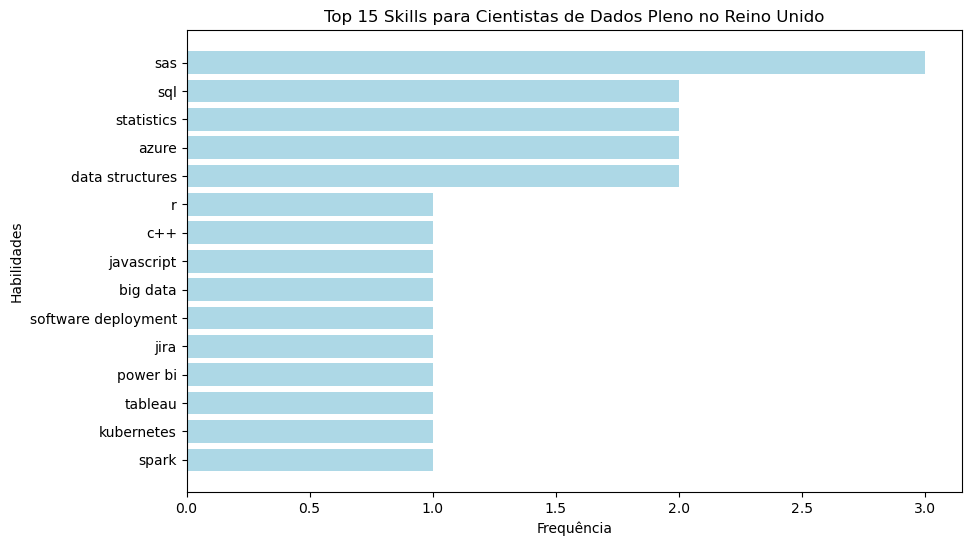

In [271]:
# Limpar e separar as habilidades nas vagas de nível Pleno
mid_level_jobs['Skills List'] = mid_level_jobs['Skills'].apply(clean_and_split_skills)

# Unir todas as listas de habilidades em uma única lista
mid_level_skills = [skill for sublist in mid_level_jobs['Skills List'] for skill in sublist]

# Contar a frequência de cada habilidade
mid_level_skill_counts = Counter(mid_level_skills)

# Converter a contagem de habilidades em um DataFrame
mid_level_skill_df = pd.DataFrame(mid_level_skill_counts.items(), columns=['Skill', 'Count']).sort_values(by='Count', ascending=False)

# Visualizar as 10 principais habilidades em vagas de nível Pleno
top_15_mid_level_skills = mid_level_skill_df.head(15)

# Gráfico de barras das 10 principais habilidades
plt.figure(figsize=(10, 6))
plt.barh(top_15_mid_level_skills['Skill'], top_15_mid_level_skills['Count'], color='lightblue')
plt.xlabel('Frequência')
plt.ylabel('Habilidades')
plt.title('Top 15 Skills para Cientistas de Dados Pleno no Reino Unido')
plt.gca().invert_yaxis()
plt.show()

In [272]:
# Filtrar as colunas de salário nas vagas de nível Pleno
mid_level_jobs_with_salary = mid_level_jobs.dropna(subset=['Average Salary'])

# Calcular o salário médio para vagas de nível Pleno
average_mid_level_salary = mid_level_jobs_with_salary['Average Salary'].mean()

print(f"Salário médio para vagas de nível Pleno: £{average_mid_level_salary:.2f}")

Salário médio para vagas de nível Pleno: £54125.00


In [273]:
# Calcular a mediana de salários para vagas de nível Pleno
median_mid_level_salary = mid_level_jobs_with_salary['Average Salary'].median()

print(f"Mediana dos salários para vagas de nível Pleno: £{median_mid_level_salary:.2f}")

Mediana dos salários para vagas de nível Pleno: £44000.00


C:\Users\luizs\AppData\Local\Temp\ipykernel_1700\3685312230.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



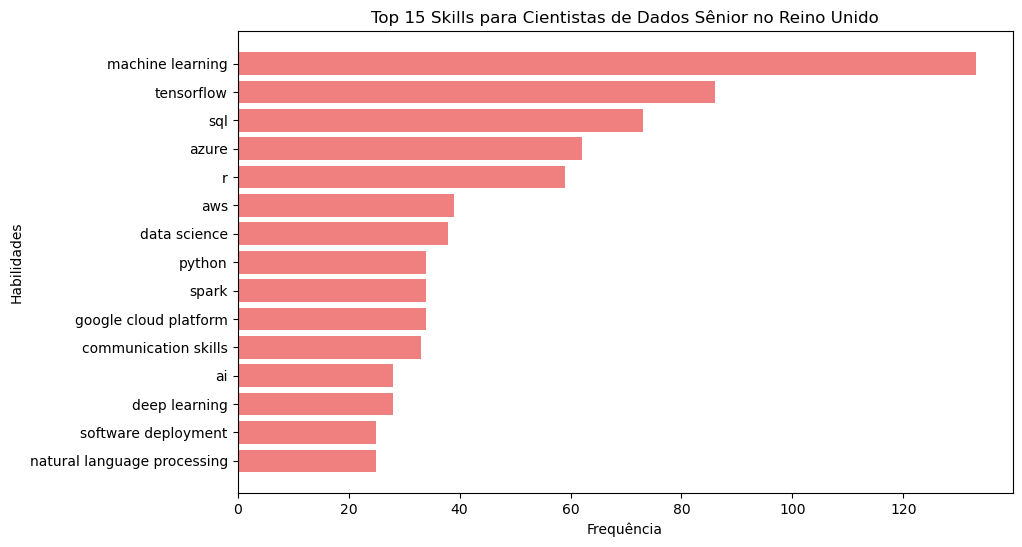

In [274]:
# Limpar e separar as habilidades nas vagas de nível Sênior
senior_jobs['Skills List'] = senior_jobs['Skills'].apply(clean_and_split_skills)

# Unir todas as listas de habilidades em uma única lista
senior_skills = [skill for sublist in senior_jobs['Skills List'] for skill in sublist]

# Contar a frequência de cada habilidade
senior_skill_counts = Counter(senior_skills)

# Converter a contagem de habilidades em um DataFrame
senior_skill_df = pd.DataFrame(senior_skill_counts.items(), columns=['Skill', 'Count']).sort_values(by='Count', ascending=False)

# Visualizar as 10 principais habilidades em vagas de nível Sênior
top_15_senior_skills = senior_skill_df.head(15)

# Gráfico de barras das 10 principais habilidades
plt.figure(figsize=(10, 6))
plt.barh(top_15_senior_skills['Skill'], top_15_senior_skills['Count'], color='lightcoral')
plt.xlabel('Frequência')
plt.ylabel('Habilidades')
plt.title('Top 15 Skills para Cientistas de Dados Sênior no Reino Unido')
plt.gca().invert_yaxis()
plt.show()

In [275]:
# Filtrar as colunas de salário nas vagas de nível Sênior
senior_jobs_with_salary = senior_jobs.dropna(subset=['Average Salary'])

# Calcular o salário médio para vagas de nível Sênior
average_senior_salary = senior_jobs_with_salary['Average Salary'].mean()

print(f"Salário médio para vagas de nível Sênior: £{average_senior_salary:.2f}")

Salário médio para vagas de nível Sênior: £68092.27


In [276]:
# Calcular a mediana de salários para vagas de nível Sênior
median_senior_level_salary = senior_jobs_with_salary['Average Salary'].median()

print(f"Mediana dos salários para vagas de nível Sênior: £{median_senior_level_salary:.2f}")

Mediana dos salários para vagas de nível Sênior: £65000.00


In [277]:
# Função para calcular média e mediana salarial
def calc_salary_stats(jobs_with_salary):
    avg_salary = jobs_with_salary['Average Salary'].mean()
    median_salary = jobs_with_salary['Average Salary'].median()
    return avg_salary, median_salary

# Filtrar as vagas de Júnior, Pleno e Sênior
junior_jobs = data[data['Job Title'].str.contains('Junior|Graduate|Entry-level|Intern', case=False, na=False)]
mid_level_jobs = data[data['Job Title'].str.contains('Mid-level|Mid|Intermediate|Experienced', case=False, na=False)]
senior_jobs = data[data['Job Title'].str.contains('Senior|Lead|Head|Principal|Manager|(Senior)|Senior,', case=False, na=False)]

# Contar o número de vagas em cada nível
num_junior_jobs = junior_jobs.shape[0]
num_mid_level_jobs = mid_level_jobs.shape[0]
num_senior_jobs = senior_jobs.shape[0]

# Calcular média e mediana salarial para cada nível
junior_jobs_with_salary = junior_jobs.dropna(subset=['Average Salary'])
mid_level_jobs_with_salary = mid_level_jobs.dropna(subset=['Average Salary'])
senior_jobs_with_salary = senior_jobs.dropna(subset=['Average Salary'])

junior_avg_salary, junior_median_salary = calc_salary_stats(junior_jobs_with_salary)
mid_level_avg_salary, mid_level_median_salary = calc_salary_stats(mid_level_jobs_with_salary)
senior_avg_salary, senior_median_salary = calc_salary_stats(senior_jobs_with_salary)

print(f"Número de vagas Júnior: {num_junior_jobs}, Salário médio: £{junior_avg_salary:.2f}, Mediana: £{junior_median_salary:.2f}")
print(f"Número de vagas Pleno: {num_mid_level_jobs}, Salário médio: £{mid_level_avg_salary:.2f}, Mediana: £{mid_level_median_salary:.2f}")
print(f"Número de vagas Sênior: {num_senior_jobs}, Salário médio: £{senior_avg_salary:.2f}, Mediana: £{senior_median_salary:.2f}")

Número de vagas Júnior: 16, Salário médio: £64904.50, Mediana: £57000.00
Número de vagas Pleno: 5, Salário médio: £54125.00, Mediana: £44000.00
Número de vagas Sênior: 326, Salário médio: £68092.27, Mediana: £65000.00


C:\Users\luizs\AppData\Local\Temp\ipykernel_1700\3302857686.py:10: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



In [278]:
import plotly.graph_objects as go

# Criar uma figura para os três box-plots
fig = go.Figure()

# Adicionar box-plot para as vagas de nível Júnior
fig.add_trace(go.Box(
    y=junior_jobs_with_salary['Average Salary'],
    name='Junior',
    marker_color='lightgreen',
    boxmean='sd'  # Exibir média e desvio padrão
))

# Adicionar box-plot para as vagas de nível Pleno (Mid-level)
fig.add_trace(go.Box(
    y=mid_level_jobs_with_salary['Average Salary'],
    name='Pleno',
    marker_color='lightblue',
    boxmean='sd'  # Exibir média e desvio padrão
))

# Adicionar box-plot para as vagas de nível Sênior
fig.add_trace(go.Box(
    y=senior_jobs_with_salary['Average Salary'],
    name='Senior',
    marker_color='lightcoral',
    boxmean='sd'  # Exibir média e desvio padrão
))

# Customizar o layout do gráfico
fig.update_layout(
    title="Comparação de Salários por Nível de Experiência",
    yaxis_title="Salário Médio (£)",
    xaxis_title="Nível Profissional",
    boxmode='group',  # Agrupar os box-plots lado a lado
    template="plotly_white"
)

# Exibir o gráfico
fig.show()

In [279]:
# Função para remover outliers com base no IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # Primeiro quartil
    Q3 = df[column].quantile(0.75)  # Terceiro quartil
    IQR = Q3 - Q1  # Intervalo interquartil
    
    # Limites superior e inferior para considerar outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtrar os dados sem os outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remover outliers dos três níveis de vagas
junior_jobs_no_outliers = remove_outliers(junior_jobs_with_salary, 'Average Salary')
mid_level_jobs_no_outliers = remove_outliers(mid_level_jobs_with_salary, 'Average Salary')
senior_jobs_no_outliers = remove_outliers(senior_jobs_with_salary, 'Average Salary')

# Criar os box-plots sem outliers
fig = go.Figure()

# Box-plot para vagas Júnior (sem outliers)
fig.add_trace(go.Box(
    y=junior_jobs_no_outliers['Average Salary'],
    name='Junior (sem outliers)',
    marker_color='lightblue',
    boxmean=True,
))

# Box-plot para vagas Sênior (sem outliers)
fig.add_trace(go.Box(
    y=senior_jobs_no_outliers['Average Salary'],
    name='Senior (sem outliers)',
    marker_color='salmon',
    boxmean=True,
))

# Ajustar o layout do gráfico
fig.update_layout(
    title="Comparação de Salários por Nível de Experiência (Sem Outliers)",
    yaxis_title="Salário Médio (£)",
    xaxis_title="Nível Profissional",
    boxmode='group',
)

# Exibir o gráfico
fig.show()

In [280]:
round(junior_jobs_no_outliers.mean(), 2)

C:\Users\luizs\AppData\Local\Temp\ipykernel_1700\892806879.py:1: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



Company Score         3.75
Average Salary    52459.38
dtype: float64

In [281]:
round(mid_level_jobs_no_outliers.mean(), 2)

C:\Users\luizs\AppData\Local\Temp\ipykernel_1700\2671367389.py:1: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



Company Score         3.63
Average Salary    43833.33
dtype: float64

In [282]:
round(senior_jobs_no_outliers.mean(), 2)

C:\Users\luizs\AppData\Local\Temp\ipykernel_1700\1224096645.py:1: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



Company Score         3.88
Average Salary    65441.74
dtype: float64

In [284]:
# Filtrar as vagas que não foram classificadas como Junior, Mid-Level ou Senior
# Supondo que já temos os DataFrames de Junior, Pleno e Senior
classified_jobs = pd.concat([junior_jobs_with_salary, mid_level_jobs_with_salary, senior_jobs_with_salary])
unclassified_jobs = data[~data.index.isin(classified_jobs.index)]  # Vagas restantes

# Exibir o número de vagas restantes
print(f"Número de vagas não classificadas (Outros): {unclassified_jobs.shape[0]}")

# Remover vagas sem salário para a análise (apenas as com salário)
unclassified_jobs_with_salary = unclassified_jobs[unclassified_jobs['Average Salary'].notnull()]

# Função para calcular a média e a mediana salarial
def calc_salary_stats(data):
    avg_salary = data['Average Salary'].mean()
    median_salary = data['Average Salary'].median()
    return avg_salary, median_salary

# Calcular média e mediana para as vagas restantes
others_avg_salary, others_median_salary = calc_salary_stats(unclassified_jobs_with_salary)

print(f"Média salarial (Outros): £{others_avg_salary:.2f}")
print(f"Mediana salarial (Outros): £{others_median_salary:.2f}")

# Box-plot para as vagas restantes
fig = go.Figure()

# Box-plot para vagas "Outros"
fig.add_trace(go.Box(
    y=unclassified_jobs_with_salary['Average Salary'],
    name='Outros',
    marker_color='darkgreen',
    boxmean=True,  # Exibir a média
    jitter=0.3,
    pointpos=-1.8,
))

# Ajustar o layout do gráfico
fig.update_layout(
    title="Box-Plot dos Salários para Vagas Não Classificadas (Outros)",
    yaxis_title="Salário Médio (£)",
    xaxis_title="Nível Profissional",
    boxmode='group',
)

# Exibir o gráfico
fig.show()

# Remover outliers nas vagas restantes usando a função remove_outliers (definida anteriormente)
unclassified_jobs_no_outliers = remove_outliers(unclassified_jobs_with_salary, 'Average Salary')

# Box-plot sem outliers para as vagas restantes
fig_no_outliers = go.Figure()

fig_no_outliers.add_trace(go.Box(
    y=unclassified_jobs_no_outliers['Average Salary'],
    name='Outros (Sem Outliers)',
    marker_color='lightcoral',
    boxmean=True,
))

# Ajustar o layout do gráfico sem outliers
fig_no_outliers.update_layout(
    title="Box-Plot dos Salários para Vagas Não Classificadas (Outros) - Sem Outliers",
    yaxis_title="Salário Médio (£)",
    xaxis_title="Nível Profissional",
    boxmode='group',
)

# Exibir o gráfico sem outliers
fig_no_outliers.show()


Número de vagas não classificadas (Outros): 478
Média salarial (Outros): £63882.06
Mediana salarial (Outros): £63000.00
